In [1]:
import os
os.chdir('../')

import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

In [2]:
with open('models/sgdc.pkl', 'rb') as file:
    sgdc = pkl.load(file)

In [3]:
data = pd.read_csv('data/selected/data.csv')

In [4]:
X, y = data.drop('estado al egreso', axis=1), data['estado al egreso']

### Decision Regions Analysis

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


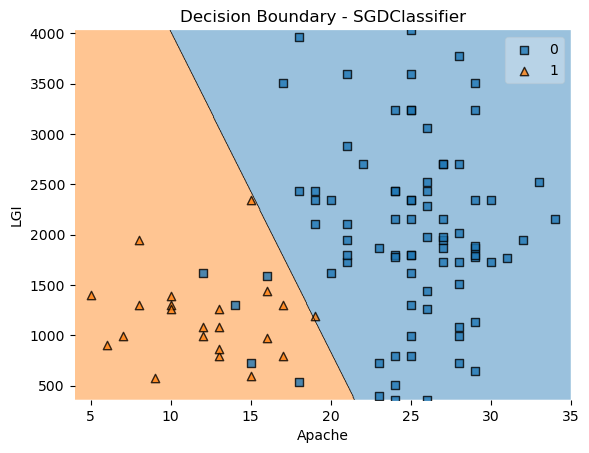

In [6]:
from mlxtend.plotting import plot_decision_regions

X_np = X.values if hasattr(X, 'values') else X
y_np = y.values if hasattr(y, 'values') else y

plot_decision_regions(X_np, y_np, clf=sgdc)
plt.title('Decision Boundary - SGDClassifier')
plt.xlabel('Apache')
plt.ylabel('LGI')
plt.show()

### Feature Importance

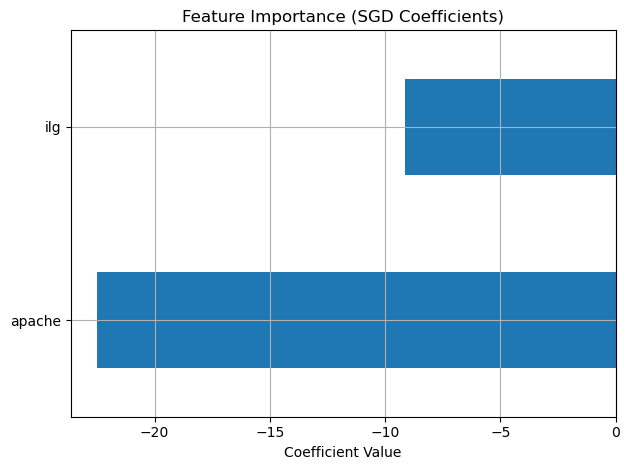

In [7]:
coef = sgdc.named_steps['estimator'].coef_[0]
features = X.columns if hasattr(X, 'columns') else ['Feature 1', 'Feature 2']

importances = pd.Series(coef, index=features)

importances.plot(kind='barh', title="Feature Importance (SGD Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()